# Modelos: KNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import util as ut

import random

<Figure size 432x288 with 0 Axes>

## Setup

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.__version__

'1.11.0'

In [8]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

<torch._C.Generator object at 0x7f48fc2856b0>

In [9]:
WEIGHTS_PATH = '../weights'

In [10]:
TRAIN = True

## Carga de dataset

In [11]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2005) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191540 entries, 0 to 191539
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      191540 non-null  int64         
 1   user_seq                     191540 non-null  int64         
 2   user_movie_tags              191540 non-null  object        
 3   user_movie_rating            191540 non-null  int64         
 4   user_movie_rating_timestamp  191540 non-null  datetime64[ns]
 5   user_movie_rating_year       191540 non-null  int64         
 6   movie_id                     191540 non-null  int64         
 7   movie_seq                    191540 non-null  int64         
 8   movie_title                  191540 non-null  string        
 9   movie_genres                 191540 non-null  object        
 10  movie_for_adults             191540 non-null  bool          
 11  movie_original_language   

In [12]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-07-26 19:20:01,306 - INFO - Train: 83.74 % - Test: 7.71 %


## Entrenamiento del modelo

In [13]:
if TRAIN:
    user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        movie_seq_col = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

<Figure size 720x432 with 2 Axes>

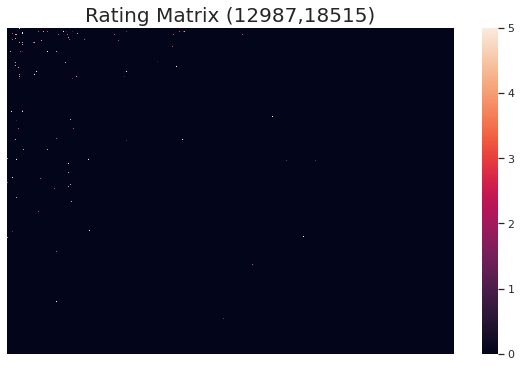

<Figure size 720x720 with 2 Axes>

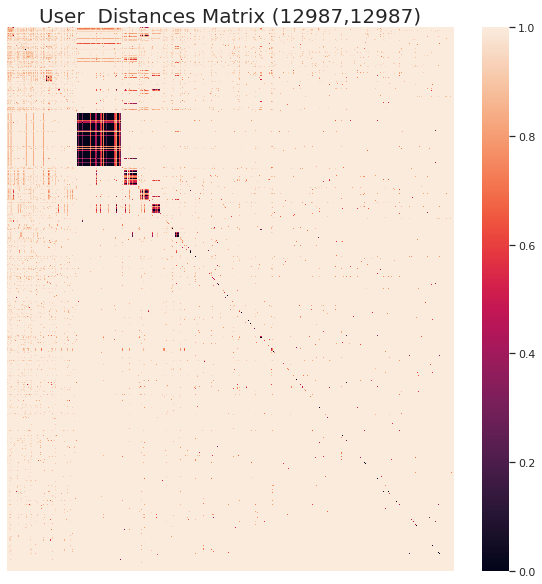

In [16]:
if TRAIN:
    user_predictor.plot()

In [15]:
if TRAIN:
    item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        movie_seq_col = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

<Figure size 720x720 with 2 Axes>

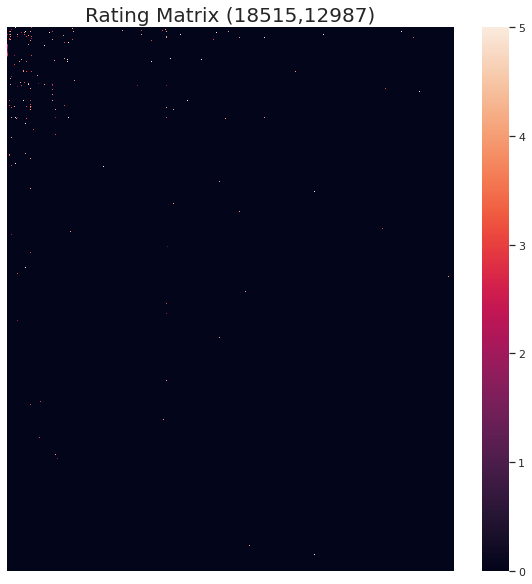

<Figure size 720x720 with 2 Axes>

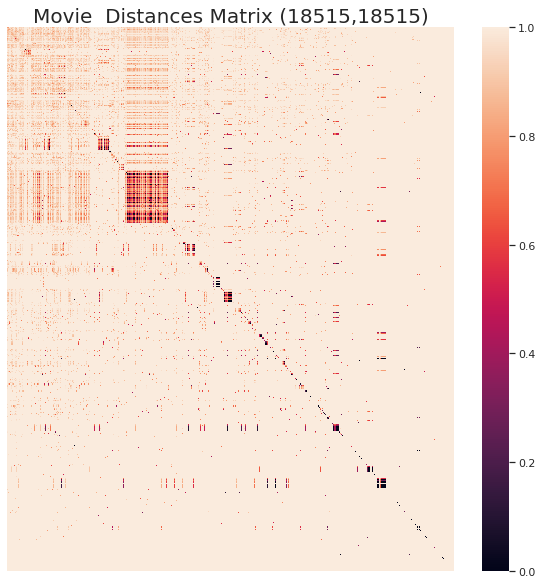

In [17]:
if TRAIN:
    item_predictor.plot()

Se guardan los modelo entrenado:

In [17]:
if TRAIN:
    user_predictor.save(WEIGHTS_PATH,'knn-user-predictor ')
    item_predictor.save(WEIGHTS_PATH,'knn-item-predictor')

In [18]:
if TRAIN:
    user_predictor.delete()
    item_predictor.delete()

## Validación del modelo

In [13]:
ut.free_gpu_memory()

In [14]:
user_predictor = ml.KNNUserBasedPredictor.from_file(WEIGHTS_PATH, 'knn-user-predictor')

In [15]:
item_predictor = ml.KNNItemBasedPredictor.from_file(WEIGHTS_PATH,'knn-item-predictor')

Decoramos los predictores un con cache para disminuir los tiempo de predicción, ya que no tiene sentido realizar dos veces la misma predicción para estos modelos donde el resultado no es aleatorio:

In [16]:
cached_user_predictor = ml.CachedPredictor(user_predictor)
cached_item_predictor = ml.CachedPredictor(item_predictor)

Armamos un ensample para validar si mejora la performance de ambos modelos:

In [17]:
ensemple_predictor = ml.EnsemplePredictor([cached_user_predictor, cached_item_predictor])

In [18]:
def validation(
    predictors, 
    n_samples    = 100, 
    batch_size   = 1000, 
    n_neighbors  = 100,
    k            = [5, 5],
    user_index   = 0,
    discretizers = [dr.between(4, 5), dr.between(3, 5)],
    summary_path = '../metrics/knn'
):
    metrics    = [mt.RMSE()]

    for k, discretizer in zip(k, discretizers):
        metrics.extend([
            mt.MeanAveragePrecisionAtk(user_index=user_index, k=k, discretizer=discretizer),
            mt.MeanUserFBetaScoreAtk(user_index=user_index, k=k, discretizer=discretizer),
            mt.MeanUserPrecisionAtk(user_index=user_index, k=k, discretizer=discretizer),
            mt.MeanUserRecallAtk(user_index=user_index, k=k, discretizer=discretizer)
        ])

    validator = ml.Validator(
        n_samples,
        batch_size,
        metrics,
        predictors
    )
    summary = validator.validate(eval_set, n_neighbors=n_neighbors)
    summary.save(summary_path)

In [ ]:
validation(
    [cached_user_predictor, cached_item_predictor, ensemple_predictor],
    n_samples    = 200,
    batch_size   = 5000,
    n_neighbors  = 5000,
    summary_path = '../metrics/knn'
)

In [3]:
summary = ml.ValidatorSummary.load('../metrics/knn')
summary.show()

,sample,RMSE,"mAP@5(4,5)","MeanUserF1Score@5(4,5)","Precision@5(4,5)","Recall@5(4,5)","mAP@5(3,5)","MeanUserF1Score@5(3,5)","Precision@5(3,5)","Recall@5(3,5)"
predictor,,,,,,,,,,
KNNUserBasedPredictor,99.5,1.493595,0.405644,0.609814,0.608780,0.609726,0.462532,0.733553,0.734211,0.733665
"Ensemple[KNNUserBasedPredictor, KNNItemBasedPredictor]",99.5,1.440606,0.397417,0.638093,0.637438,0.637978,0.459241,0.649969,0.651039,0.650548
KNNItemBasedPredictor,99.5,1.802944,0.383683,0.617377,0.617542,0.617251,0.452825,0.670432,0.670516,0.671687


<Figure size 1440x360 with 1 Axes>

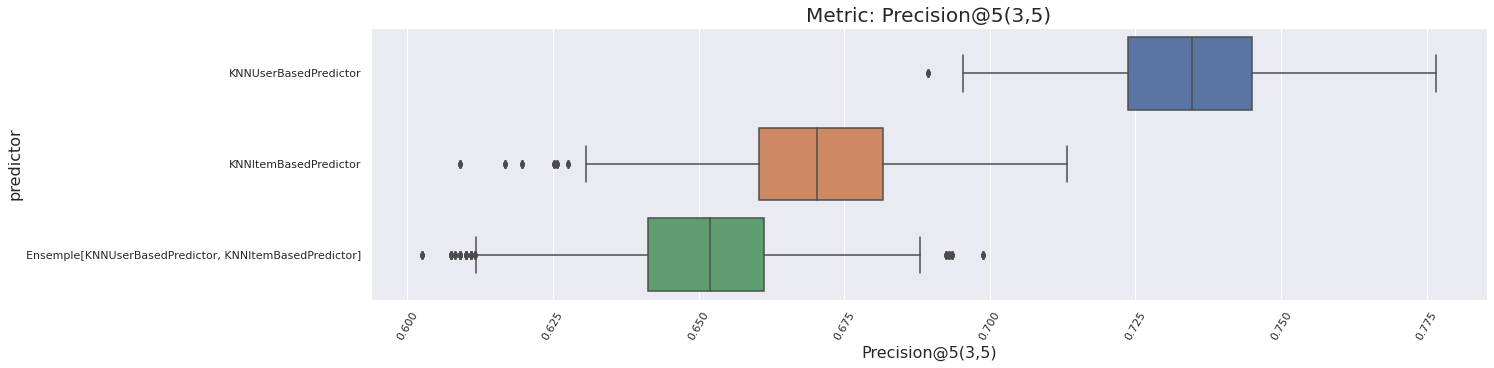

<Figure size 1440x360 with 1 Axes>

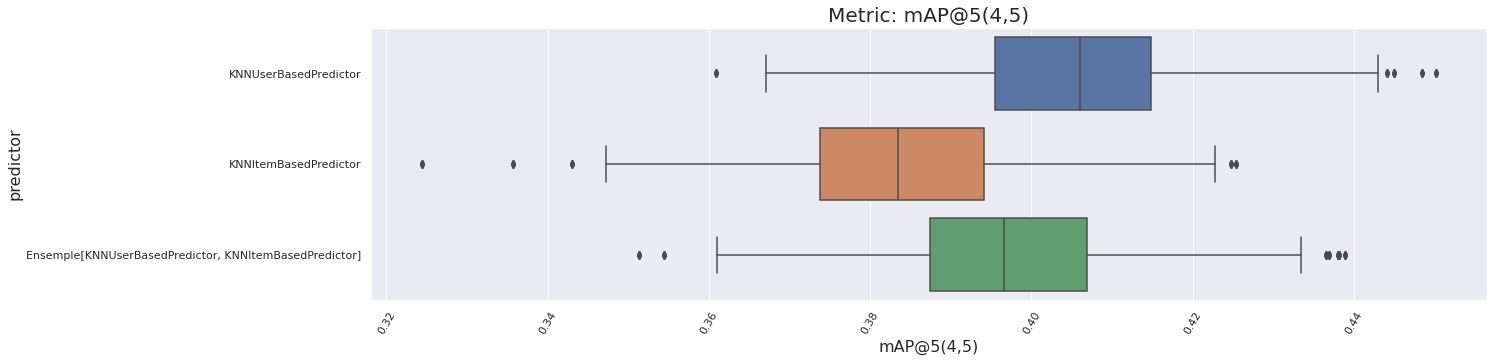

<Figure size 1440x360 with 1 Axes>

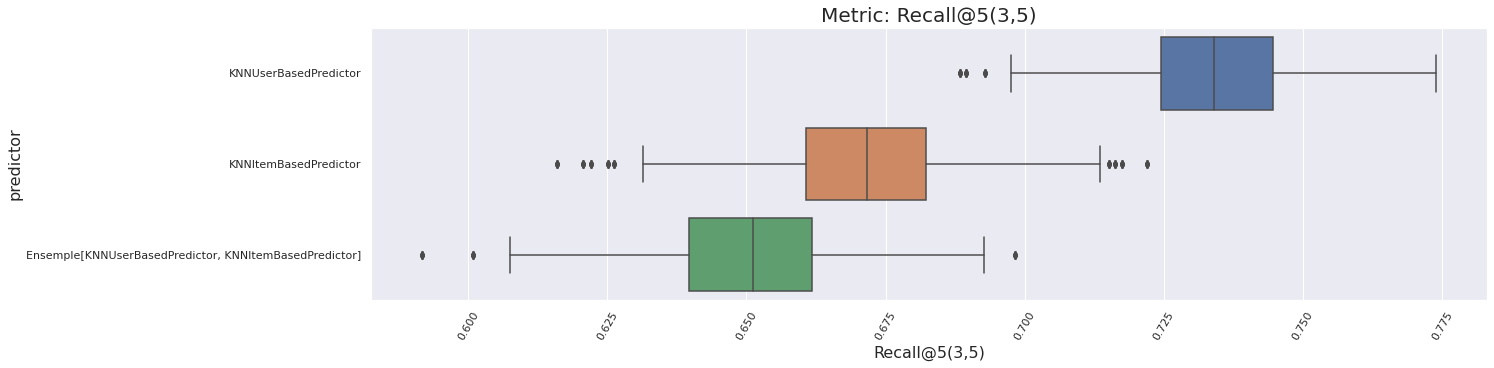

<Figure size 1440x360 with 1 Axes>

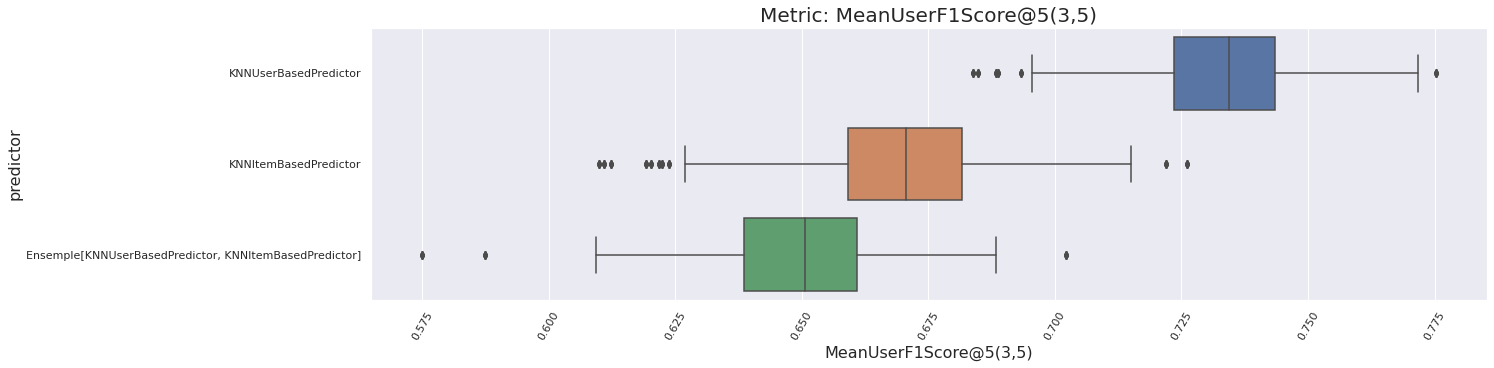

<Figure size 1440x360 with 1 Axes>

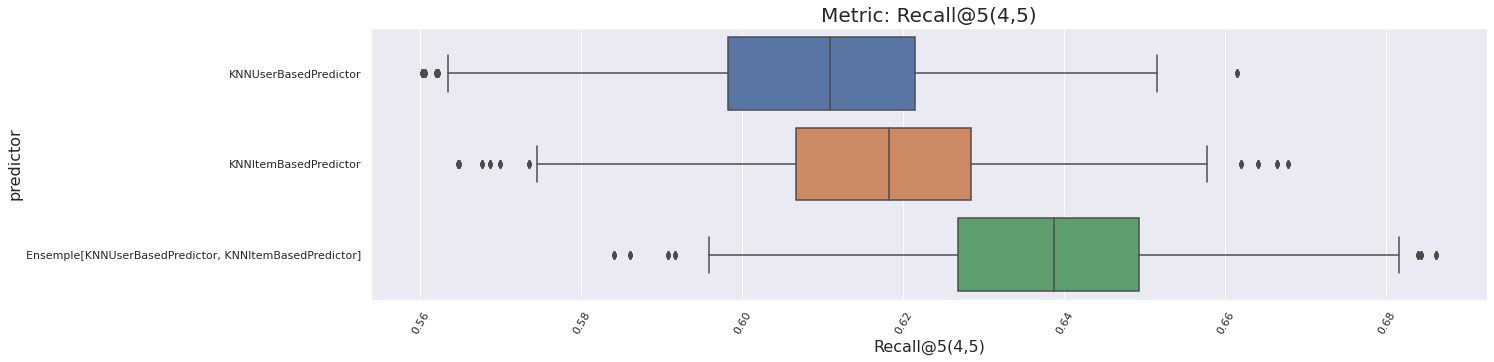

<Figure size 1440x360 with 1 Axes>

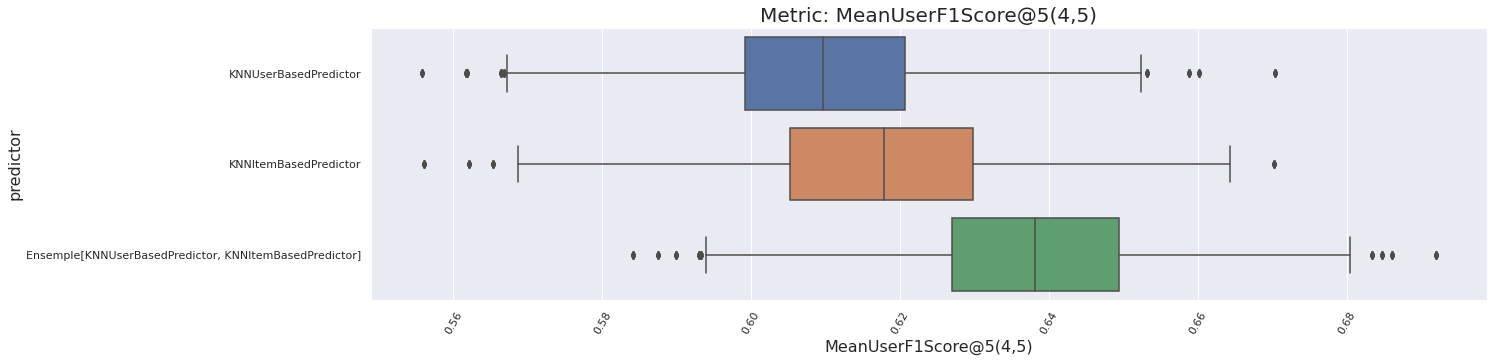

<Figure size 1440x360 with 1 Axes>

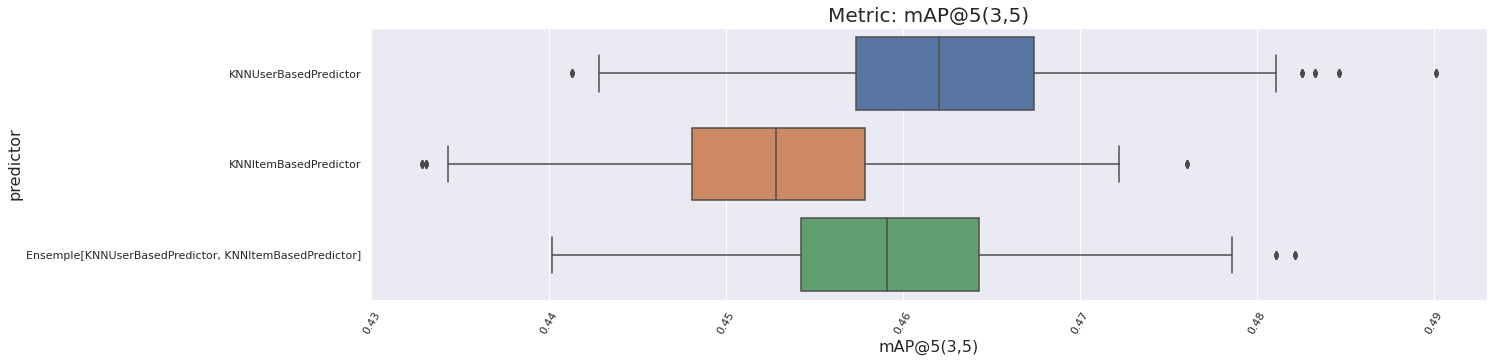

<Figure size 1440x360 with 1 Axes>

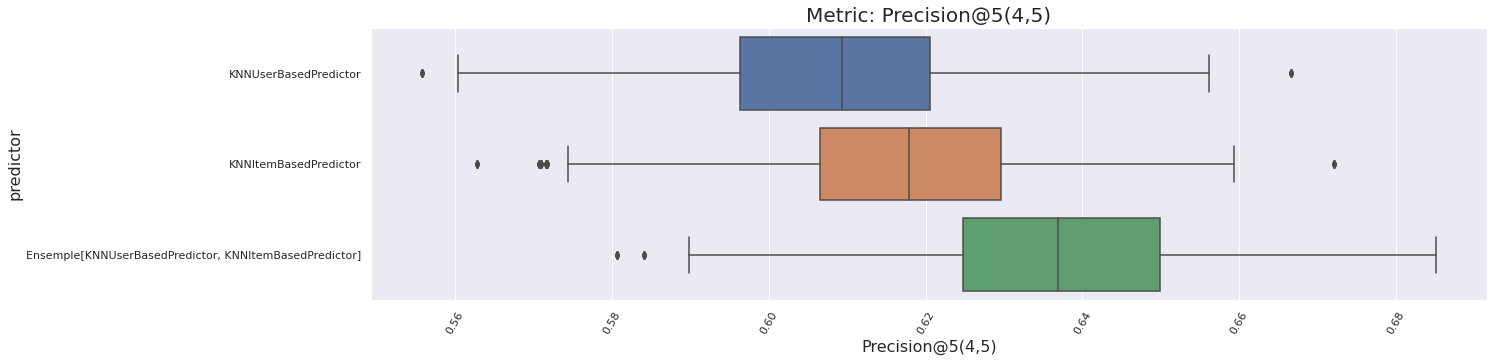

<Figure size 1440x360 with 1 Axes>

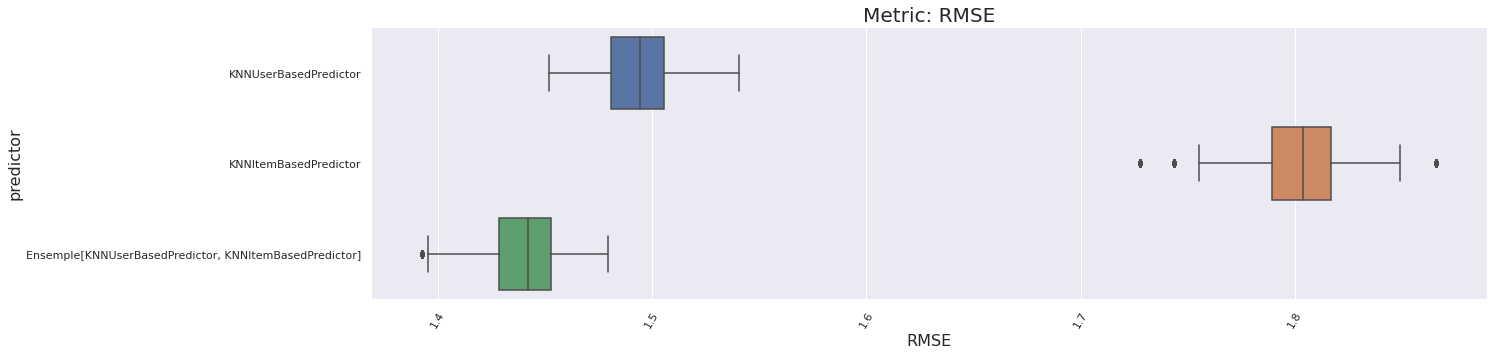

<Figure size 1440x360 with 2 Axes>

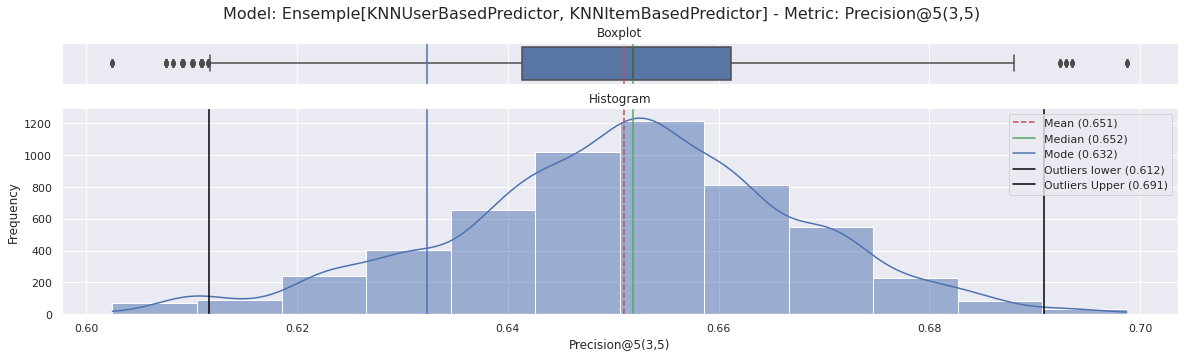

<Figure size 1440x360 with 2 Axes>

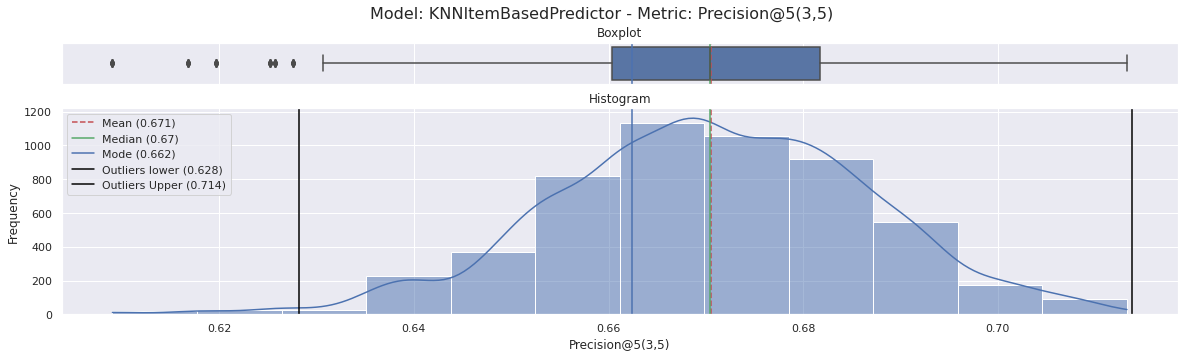

<Figure size 1440x360 with 2 Axes>

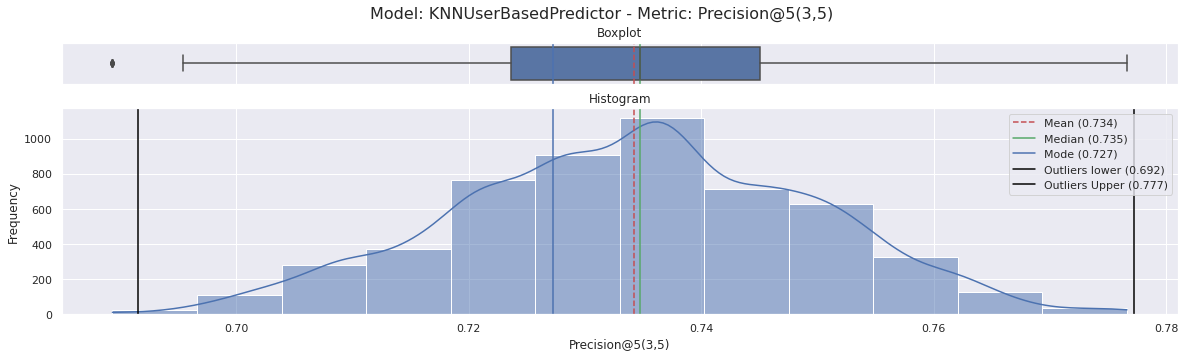

<Figure size 1440x360 with 2 Axes>

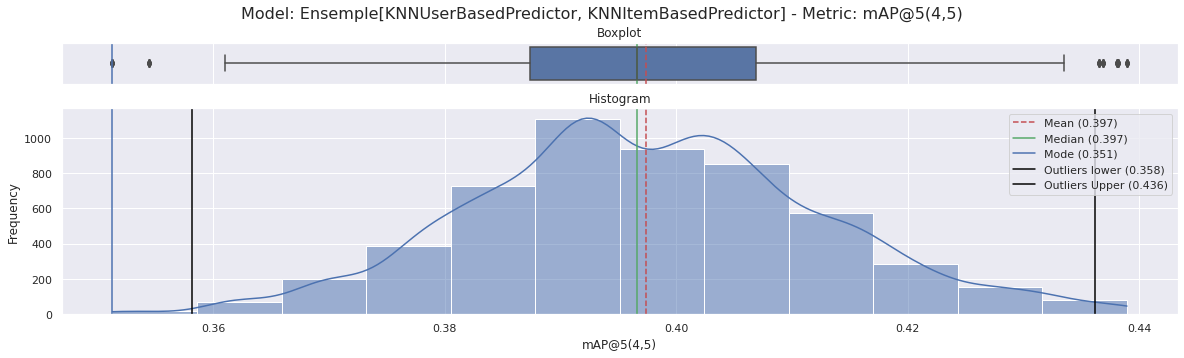

<Figure size 1440x360 with 2 Axes>

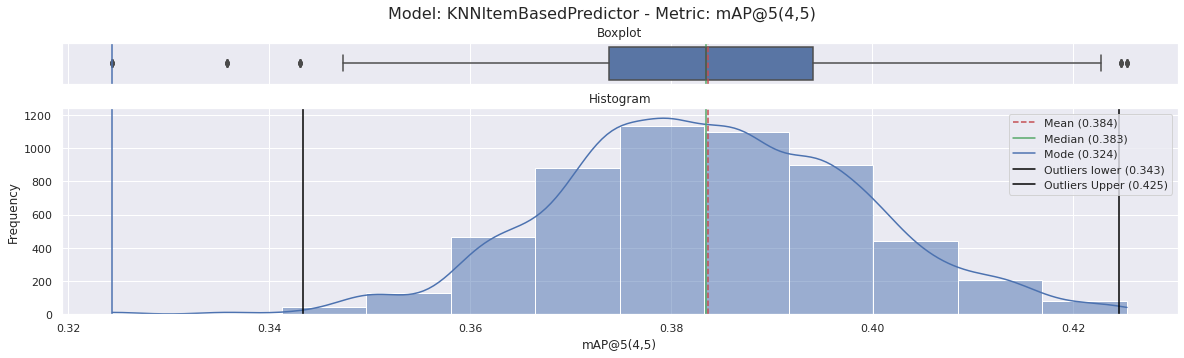

<Figure size 1440x360 with 2 Axes>

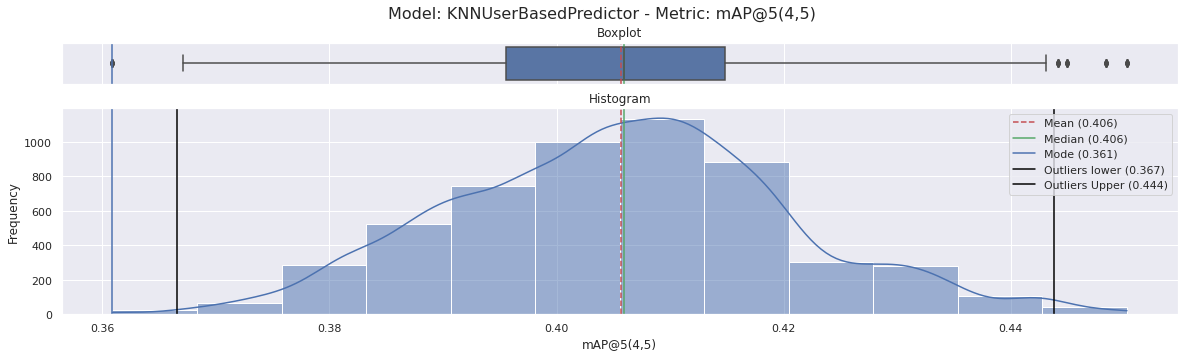

<Figure size 1440x360 with 2 Axes>

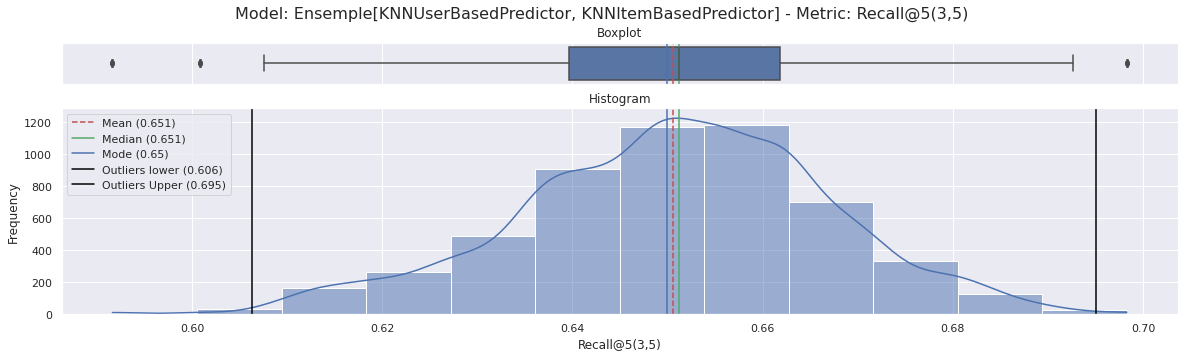

<Figure size 1440x360 with 2 Axes>

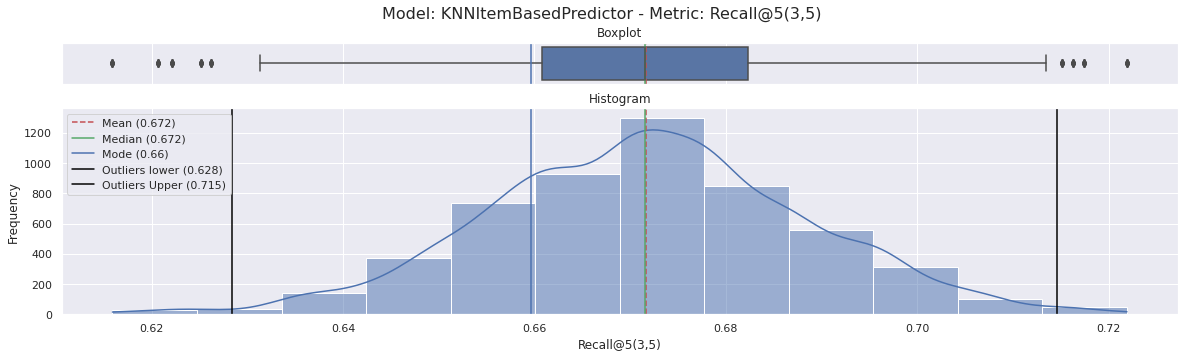

<Figure size 1440x360 with 2 Axes>

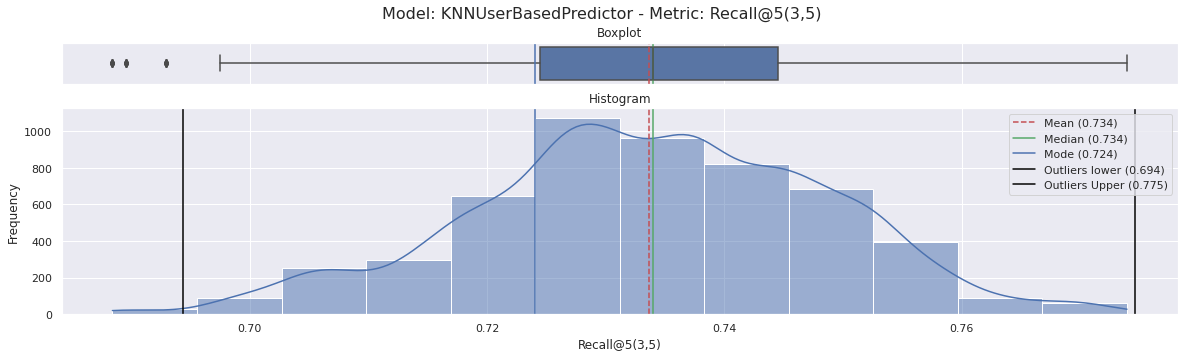

<Figure size 1440x360 with 2 Axes>

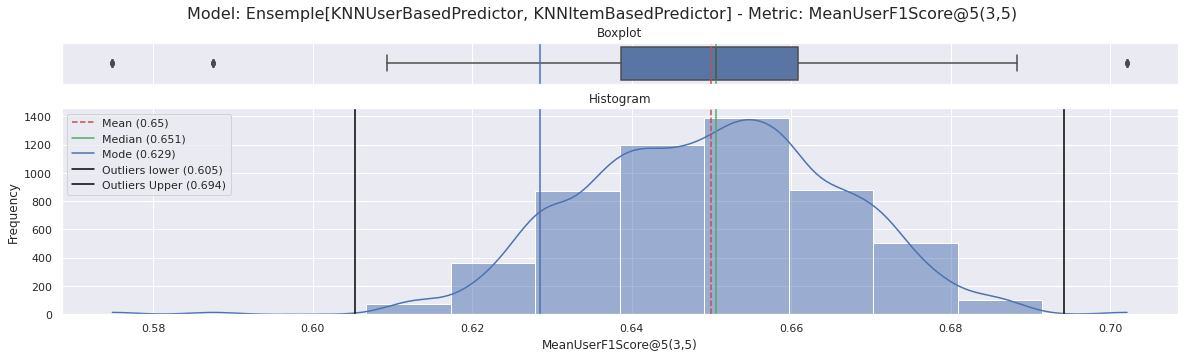

<Figure size 1440x360 with 2 Axes>

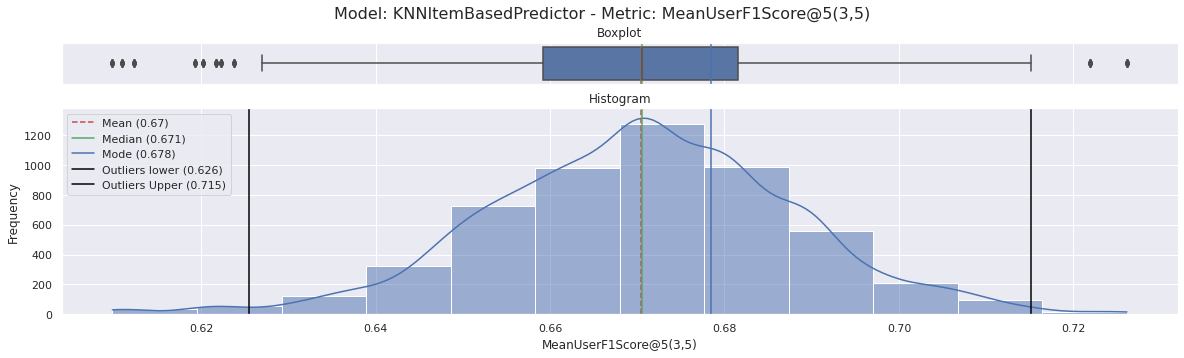

<Figure size 1440x360 with 2 Axes>

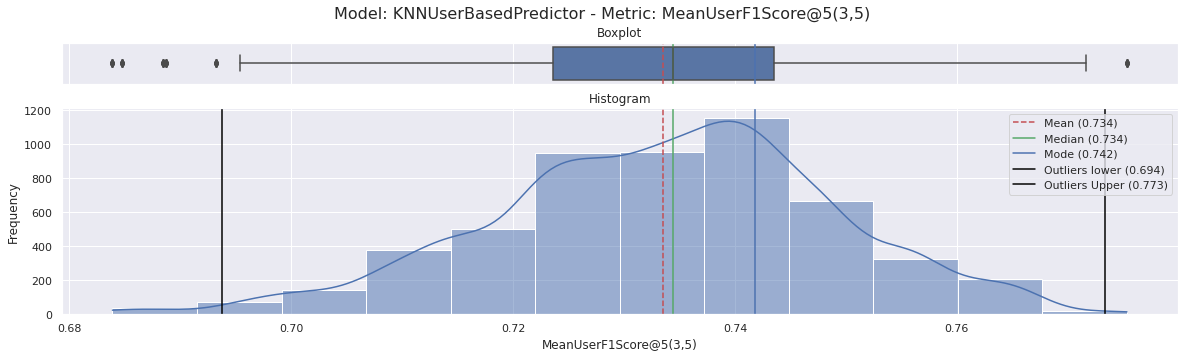

<Figure size 1440x360 with 2 Axes>

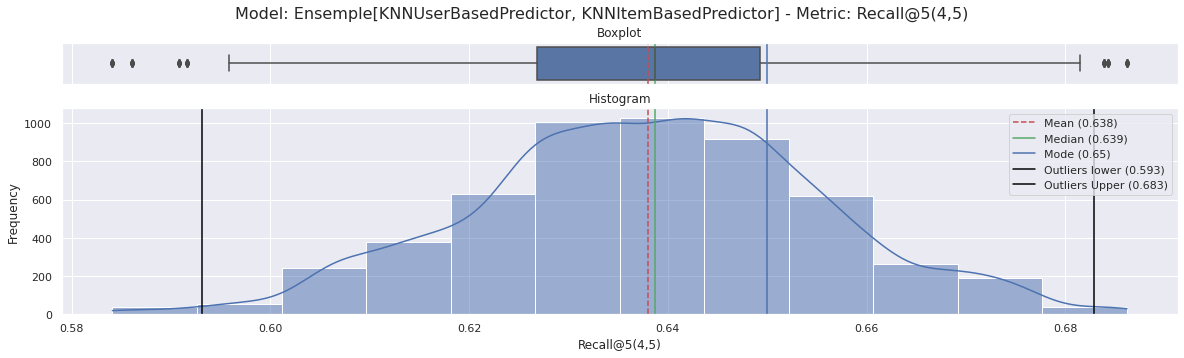

<Figure size 1440x360 with 2 Axes>

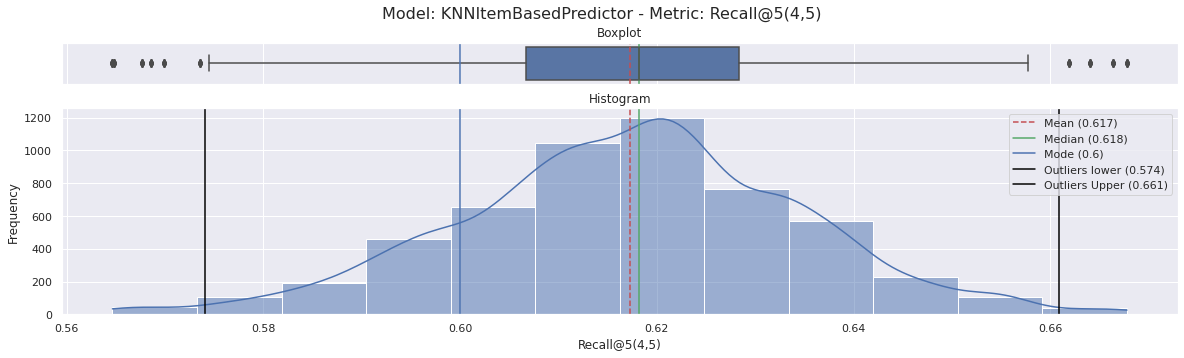

<Figure size 1440x360 with 2 Axes>

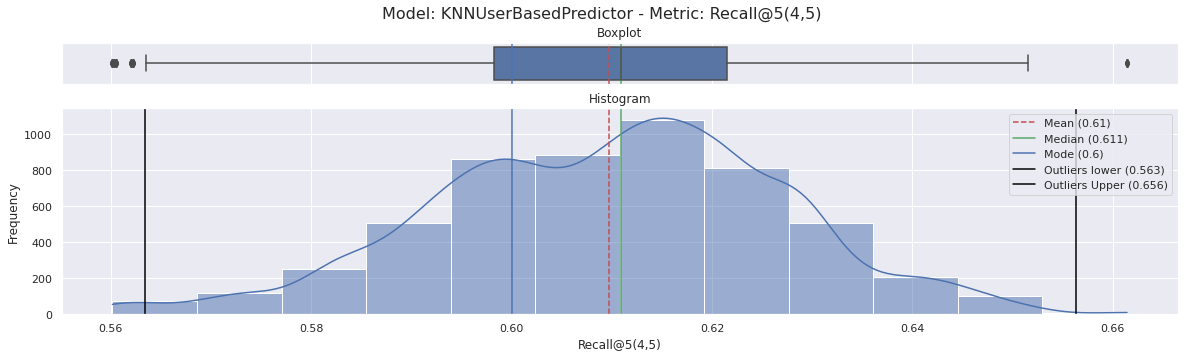

<Figure size 1440x360 with 2 Axes>

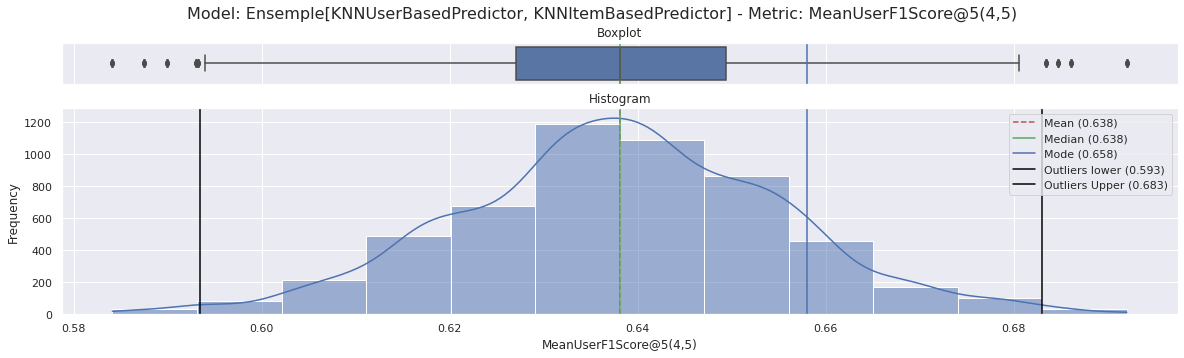

<Figure size 1440x360 with 2 Axes>

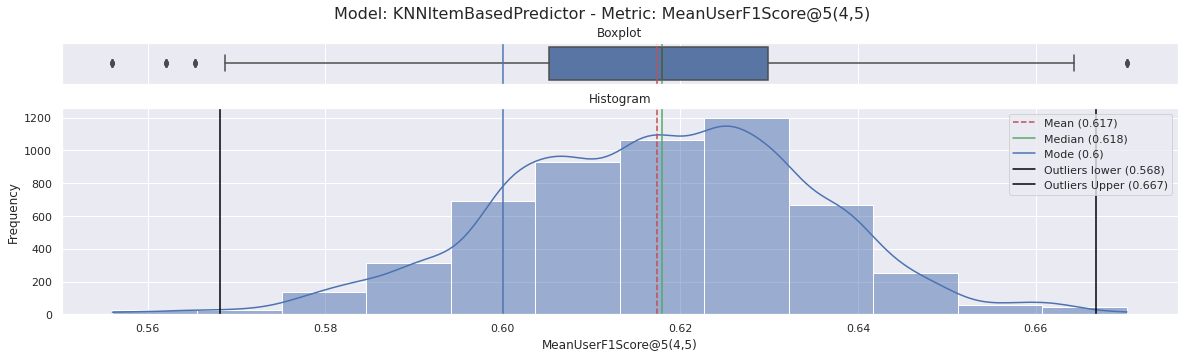

<Figure size 1440x360 with 2 Axes>

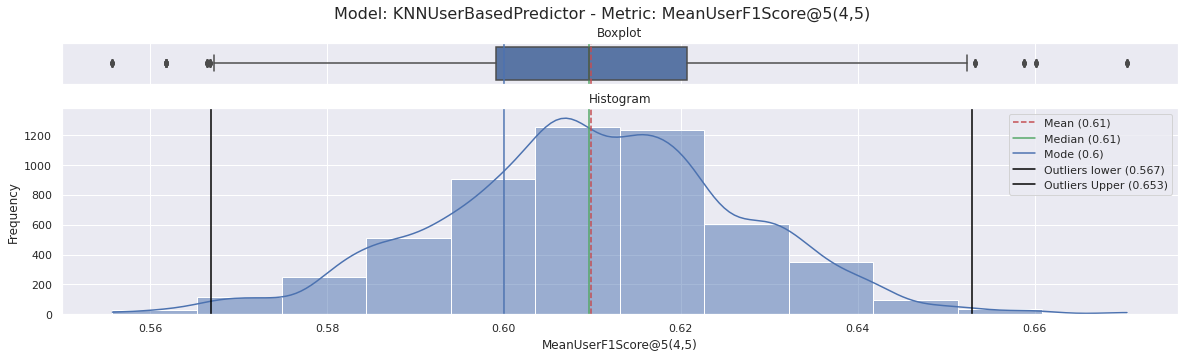

<Figure size 1440x360 with 2 Axes>

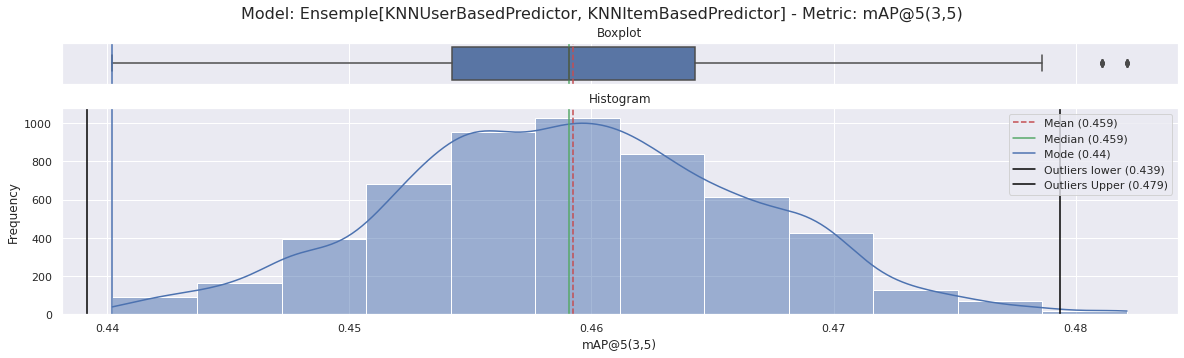

<Figure size 1440x360 with 2 Axes>

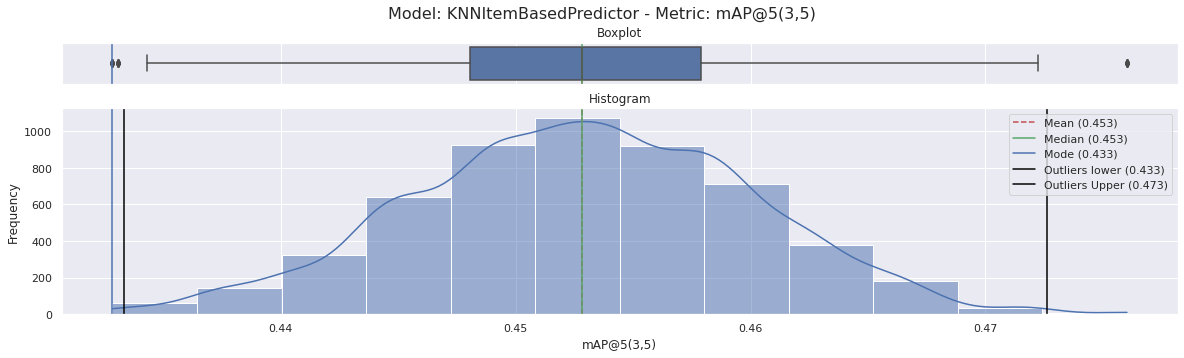

<Figure size 1440x360 with 2 Axes>

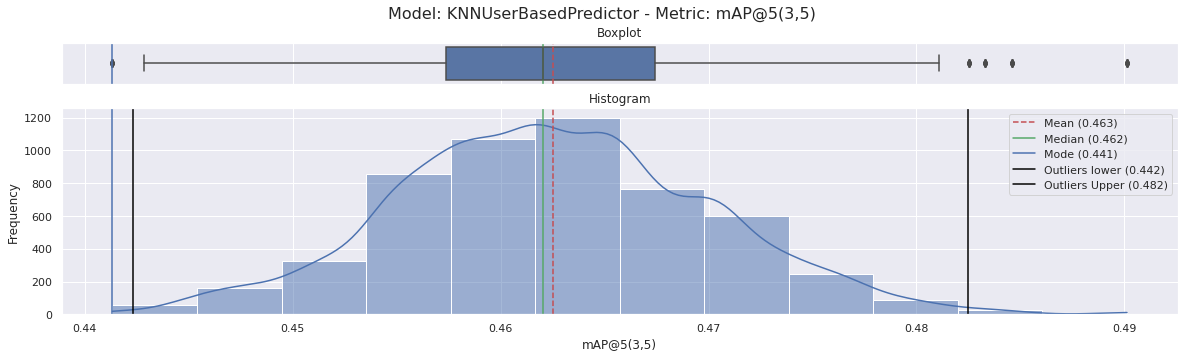

<Figure size 1440x360 with 2 Axes>

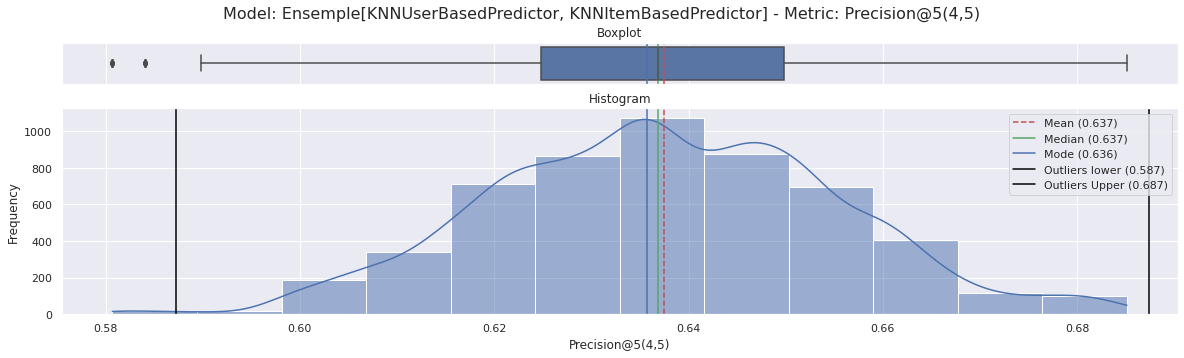

<Figure size 1440x360 with 2 Axes>

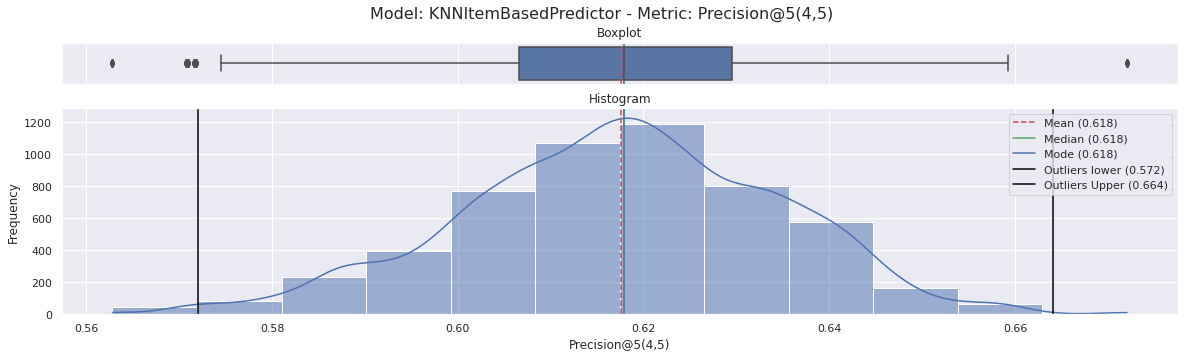

<Figure size 1440x360 with 2 Axes>

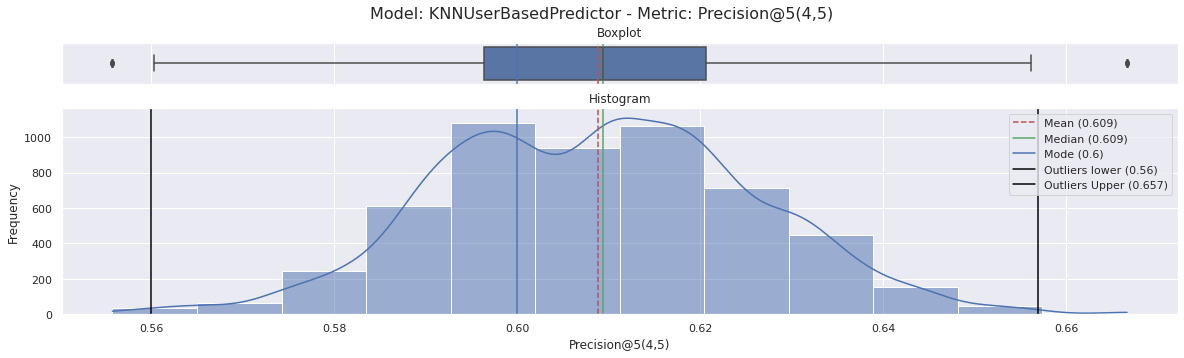

<Figure size 1440x360 with 2 Axes>

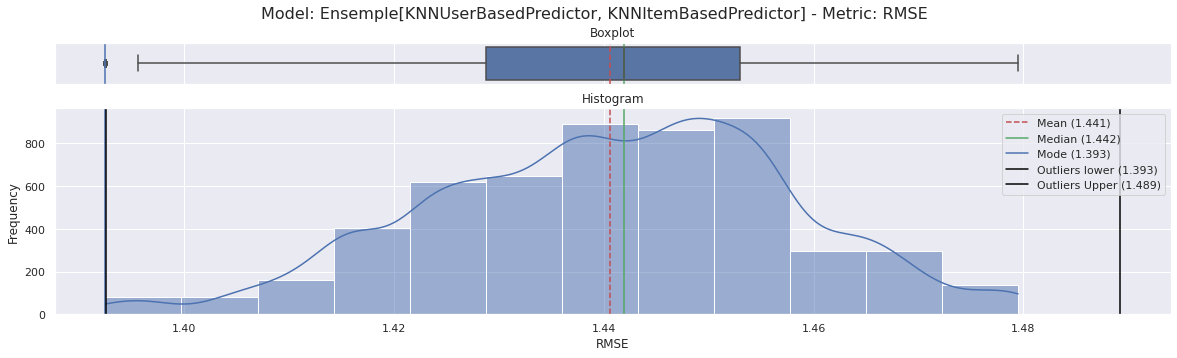

<Figure size 1440x360 with 2 Axes>

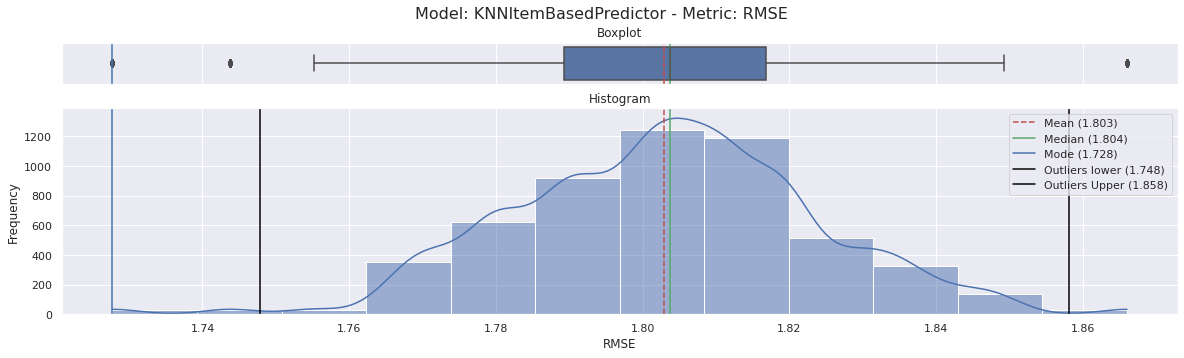

<Figure size 1440x360 with 2 Axes>

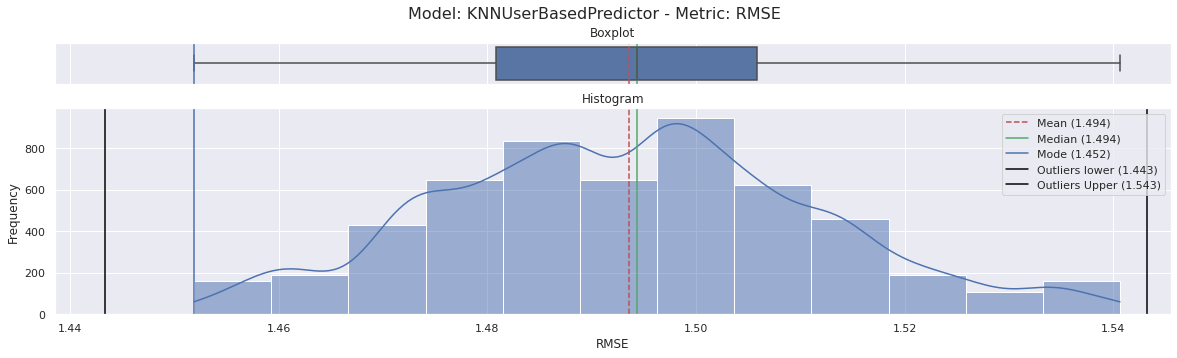

In [4]:
summary.plot(bins=12)